In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         52 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  192
  On-line CPU(s) list:   0-191
Vendor ID:               AuthenticAMD
  Model name:            AMD EPYC 9684X 96-Core Processor
    CPU family:          25
    Model:               17
    Thread(s) per core:  1
    Core(s) per socket:  96
    Socket(s):           2
    Stepping:            2
    Frequency boost:     enabled
    CPU max MHz:         3715.4290
    CPU min MHz:         1500.0000
    BogoMIPS:            5099.84
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n
                         x mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_go
                         od nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl p
                         ni pclmulqdq monitor sss

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import time
import seaborn as sns
from scipy.optimize import fmin, minimize, LinearConstraint, Bounds

from efficient_fpt.multi_stage_cy import compute_loss_parallel, print_num_threads


data = pickle.load(open("addm_data_20251015-163921.pkl", "rb"))

In [3]:
DATA_TYPE = np.float64

a = data["a"]
b = data["b"]
x0 = data["x0"]
# mu1_true = data["mu1"]
# mu2_true = data["mu2"]
eta_true = data["eta"]
kappa_true = data["kappa"]
r1_data = data["r1_data"]
r2_data = data["r2_data"]
flag_data = data["flag_data"].astype(np.int32)

sigma = data["sigma"]
T = data["T"]

mu1_true_data = kappa_true * (r1_data - eta_true * r2_data)
mu2_true_data = kappa_true * (eta_true * r1_data - r2_data)

mu_true_data = data["mu_array_padded_data"].astype(DATA_TYPE)
sacc_data = data["sacc_array_padded_data"].astype(DATA_TYPE)
length_data = data["d_data"].astype(np.int32)
rt_data = data["decision_data"][:, 0].astype(DATA_TYPE)
choice_data = data["decision_data"][:, 1].astype(np.int32)

num_data, max_d = mu_true_data.shape
# # set data range if necessary
# start_index, end_index = 0, 50000
# num_data = min(end_index, num_data) - min(start_index, num_data)
# mu_array_true_data, mu1_true_data, mu2_true_data, sacc_array_data, length_data, rt_data, choice_data, flag_data = (
#     mu_array_true_data[indices_range],
#     mu1_true_data[indices_range],
#     mu2_true_data[indices_range],
#     sacc_array_data[indices_range],
#     length_data[indices_range],
#     rt_data[indices_range],
#     choice_data[indices_range],
#     flag_data[indices_range],
# )

In [4]:
print_num_threads()
print("# data =", num_data)

Number of available threads: 64
# data = 50000


In [5]:
num_iter = 10
start_time = time.time()
for _ in range(num_iter):
    loss = compute_loss_parallel(
        mu1_true_data,
        mu2_true_data,
        rt_data,
        choice_data,
        flag_data,
        sacc_data,
        length_data,
        max_d,
        sigma,
        a,
        b,
        x0,
        num_threads=32,
    )
end_time = time.time()
print(f"Likelihood evaluation time: {(end_time - start_time) / num_iter:.3f} s")

Likelihood evaluation time: 0.230 s


### Maximum Likelihood Estimation

In [6]:
# Constraint optimization for searching all parameters
print("\nNumerical optimization for eta, kappa, a, b, x0:")
method = "trust-constr"
print("Using " + method)
func = lambda paras: compute_loss_parallel(
    paras[1] * (r1_data - paras[0] * r2_data),
    paras[1] * (paras[0] * r1_data - r2_data),
    rt_data,
    choice_data,
    flag_data,
    sacc_data,
    length_data,
    max_d,
    sigma,
    paras[2],
    paras[3],
    paras[4],
)
bounds = Bounds([0, 0, 0, 0, -np.inf], [1, np.inf, np.inf, np.inf, np.inf])
con = LinearConstraint(
    [[0, 0, 1, -np.max(rt_data), 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, -1]],
    lb=[0, 0, 0],
    ub=[np.inf, np.inf, np.inf],
)
initial_guess = [0.5, 1, 1.0, 0.0, 0.0]
print("Initial guess:", initial_guess)
print()
start_time = time.time()
paras_opt_result = minimize(
    func,
    x0=initial_guess,
    bounds=bounds,
    constraints=con,
    method=method,
    options={"verbose": 1},
)
print(f"Total time: {time.time() - start_time:.3f} seconds")
print(paras_opt_result)


Numerical optimization for eta, kappa, a, b, x0:
Using trust-constr
Initial guess: [0.5, 1, 1.0, 0.0, 0.0]

`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 462, CG iterations: 183, optimality: 3.39e-08, constraint violation: 0.00e+00, execution time: 1.7e+02 s.
Total time: 170.062 seconds
           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 1.485249673525234
                 x: [ 6.972e-01  5.018e-01  2.104e+00  3.043e-01 -1.962e-01]
               nit: 67
              nfev: 462
              njev: 77
              nhev: 0
          cg_niter: 183
      cg_stop_cond: 2
              grad: [ 4.470e-08  1.490e-08  9.209e-08 -1.192e-07 -1.490e-08]
   lagrangian_grad: [ 3.476e-09  2.176e-09  3.392e-08  5.307e-09 -1.229e-08]
            constr: [array([ 3.583e-01,  1.907e+00,  2.300e+00]), array([ 6.972e-01,  5.018e-01,  2.104e+00,  3.043e-01,
                           -

In [7]:
mle = paras_opt_result["x"]
print("True and estimated value of parameters:")
print(f"eta: {eta_true:.5f}, {mle[0]:.5f}")
print(f"kappa: {kappa_true:.5f}, {mle[1]:.5f}")
print(f"a: {a:.5f}, {mle[2]:.5f}")
print(f"b: {b:.5f}, {mle[3]:.5f}")
print(f"x0: {x0:.5f}, {mle[4]:.5f}")

True and estimated value of parameters:
eta: 0.70000, 0.69717
kappa: 0.50000, 0.50180
a: 2.10000, 2.10363
b: 0.30000, 0.30431
x0: -0.20000, -0.19619


In [8]:
n_boot = 1000
alpha = 0.05  # 95% confidence interval

In [9]:


start_time = time.time()
bootstrap_estimates = np.zeros((n_boot, 5))
# Bootstrap resampling
for i in range(n_boot):
    if i % 100 == 0:
        print(f"Bootstrap iteration {i} takes {time.time() - start_time:.3f} seconds")
    indices = np.random.choice(len(rt_data), size=len(rt_data), replace=True)
    # Resample data
    r1_boot = r1_data[indices]
    r2_boot = r2_data[indices]
    rt_boot = rt_data[indices]
    choice_boot = choice_data[indices]
    flag_boot = flag_data[indices]
    sacc_boot = sacc_data[indices, :]
    length_boot = length_data[indices]
    # Define the function for resampled data
    func_boot = lambda paras: compute_loss_parallel(
        paras[1] * (r1_boot - paras[0] * r2_boot),
        paras[1] * (paras[0] * r1_boot - r2_boot),
        rt_boot,
        choice_boot,
        flag_boot,
        sacc_boot,
        length_boot,
        max_d,
        sigma,
        paras[2],
        paras[3],
        paras[4],
    )
    # Optimize for bootstrap sample
    result = minimize(func_boot, x0=mle, bounds=bounds, constraints=con, method=method)
    if result.success:
        bootstrap_estimates[i, :] = result.x
    else:
        print(f"Warning: Optimization failed for bootstrap iteration {i}")

print(f"Total time: {time.time() - start_time:.3f} seconds")

Bootstrap iteration 0 takes 0.000 seconds
Bootstrap iteration 100 takes 7158.010 seconds
Bootstrap iteration 200 takes 14424.886 seconds
Bootstrap iteration 300 takes 21388.538 seconds
Bootstrap iteration 400 takes 28818.152 seconds
Bootstrap iteration 500 takes 35862.675 seconds
Bootstrap iteration 600 takes 43540.371 seconds
Bootstrap iteration 700 takes 50734.466 seconds
Bootstrap iteration 800 takes 57741.934 seconds
Bootstrap iteration 900 takes 65512.868 seconds


/users/sliu167/.conda/envs/cddm/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Total time: 73327.455 seconds


In [9]:
# np.save("bootstrap_" + time.strftime("%Y%m%d-%H%M%S") + ".npy", bootstrap_estimates)
bootstrap_estimates = np.load("bootstrap_20251016-131116.npy")

In [10]:
# Compute percentiles for pivotal confidence intervals
bootstrap_means = np.mean(bootstrap_estimates, axis=0)
lower_pivot = 2 * bootstrap_means - np.percentile(bootstrap_estimates, 100 * (1 - alpha / 2), axis=0)
upper_pivot = 2 * bootstrap_means - np.percentile(bootstrap_estimates, 100 * (alpha / 2), axis=0)

# Store results
bootstrap_ci = np.vstack((lower_pivot, upper_pivot)).T

In [11]:
bootstrap_ci

array([[ 0.68982142,  0.70468598],
       [ 0.49679184,  0.50720706],
       [ 2.0927873 ,  2.1155957 ],
       [ 0.29976246,  0.30884447],
       [-0.20453138, -0.18830665]])

##### prior

In [12]:
from scipy.stats import beta, lognorm, gamma


def log_prior(z):
    M = float(max(rt_data))
    eta, kappa, a, b, x0 = z
    # --- hard constraints ---
    if not (0.0 < eta < 1.0):
        return -np.inf
    if not (kappa > 0.0 and a > 0.0):
        return -np.inf
    if not (0.0 < b < a / M):
        return -np.inf
    if not (-a < x0 < a):
        return -np.inf
    log_eta_prior = beta.logpdf(eta, a=2, b=2)
    log_kappa_prior = gamma.logpdf(kappa, a=2, scale=1/4.0) # lognorm.logpdf(kappa, s=1, scale=np.exp(0))
    log_a_prior = gamma.logpdf(a, a=2, scale=1/1.0) # lognorm.logpdf(a, s=1, scale=np.exp(0))
    log_b_prior = beta.logpdf(b, a=2, b=2, loc=0, scale=a / np.max(rt_data))
    log_x0_prior = beta.logpdf(x0, a=2, b=2, loc=-a, scale=2 * a)
    return log_eta_prior + log_kappa_prior + log_a_prior + log_b_prior + log_x0_prior

### Maximum a posteriori estimation

In [13]:
print("\n")
print_num_threads()
print("# data =", num_data)

# Constraint optimization for searching all parameters
print("\nNumerical optimization for eta, kappa:")
method = "trust-constr"
print("Using " + method)
func = lambda paras: -log_prior(
    np.array([paras[0], paras[1], paras[2], paras[3], paras[4]])
) + num_data * compute_loss_parallel(
    paras[1] * (r1_data - paras[0] * r2_data),
    paras[1] * (paras[0] * r1_data - r2_data),
    rt_data,
    choice_data,
    flag_data,
    sacc_data,
    length_data,
    max_d,
    sigma,
    paras[2],
    paras[3],
    paras[4],
)
bounds = Bounds([0, 0, 0, 0, -np.inf], [1, np.inf, np.inf, np.inf, np.inf])
con = LinearConstraint(
    [[0, 0, 1, -np.max(rt_data), 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, -1]],
    lb=[0, 0, 0],
    ub=[np.inf, np.inf, np.inf],
)
initial_guess = [0.5, 1, 1, 0.1, 0]
print("Initial guess:", initial_guess)
print()
start_time = time.time()
paras_opt_result = minimize(
    func,
    x0=initial_guess,
    bounds=bounds,
    constraints=con,
    method=method,
    options={"verbose": 1},
)
print(f"Total time: {time.time() - start_time:.3f} seconds")
print(paras_opt_result)



Number of available threads: 64
# data = 50000

Numerical optimization for eta, kappa:
Using trust-constr
Initial guess: [0.5, 1, 1, 0.1, 0]

`xtol` termination condition is satisfied.
Number of iterations: 125, function evaluations: 228, CG iterations: 221, optimality: 1.99e-03, constraint violation: 0.00e+00, execution time: 8.1e+01 s.
Total time: 82.897 seconds
           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 74263.73308136796
                 x: [ 6.972e-01  5.018e-01  2.103e+00  3.042e-01 -1.962e-01]
               nit: 125
              nfev: 228
              njev: 38
              nhev: 0
          cg_niter: 221
      cg_stop_cond: 4
              grad: [-2.930e-03  3.906e-03  2.786e-03 -1.270e-02  2.930e-03]
   lagrangian_grad: [-2.099e-04  7.857e-04  2.455e-04 -6.490e-06  1.987e-03]
            constr: [array([ 3.585e-01,  1.907e+00,  2.300e+00]), array([ 6.972e-01,  5.018e-01,  2.103e+00,  3.0

In [14]:
mape = paras_opt_result["x"]
print("True and estimated value of parameters:")
print(f"eta: {eta_true:.5f}, {mape[0]:.5f}")
print(f"kappa: {kappa_true:.5f}, {mape[1]:.5f}")
print(f"a: {a:.5f}, {mape[2]:.5f}")
print(f"b: {b:.5f}, {mape[3]:.5f}")
print(f"x0: {x0:.5f}, {mape[4]:.5f}")

True and estimated value of parameters:
eta: 0.70000, 0.69715
kappa: 0.50000, 0.50178
a: 2.10000, 2.10349
b: 0.30000, 0.30425
x0: -0.20000, -0.19617


### MCMC and Bayesian Inference

In [15]:
def z_to_u(z):
    """
    Vectorized: z[..., 0:5] = (eta, kappa, a, b, x0)
    Returns u with the same leading shape and last dim = 5:
        u = (logit(eta), log(kappa), log(a), logit(b*M/a), log((a+x0)/(a-x0)))
    """
    z = np.asarray(z, dtype=float)
    if z.shape[-1] != 5:
        raise ValueError("z_to_u: last dimension must be 5 (eta, kappa, a, b, x0).")

    M = float(np.max(rt_data))

    eta = z[..., 0]
    kappa = z[..., 1]
    a     = z[..., 2]
    b     = z[..., 3]
    x0    = z[..., 4]

    # Transforms (broadcast-safe)
    u_eta = np.log(eta) - np.log1p(-eta)          # logit(eta)
    u_kappa = np.log(kappa)                              # log(kappa)
    u_a     = np.log(a)                                  # log(a)
    t_b     = b * M / a                                  # in (0,1)
    u_b     = np.log(t_b) - np.log1p(-t_b)               # logit(t_b)
    u_x0    = np.log(a + x0) - np.log(a - x0)            # log((a+x0)/(a-x0))

    return np.stack([u_eta, u_kappa, u_a, u_b, u_x0], axis=-1)


def u_to_z(u):
    """
    Vectorized: u[..., 0:5] = (u_eta, u_kappa, u_a, u_b, u_x0)
    Returns z with the same leading shape and last dim = 5:
        z = (eta, kappa, a, b, x0) with constraints enforced by construction.
    """
    u = np.asarray(u, dtype=float)
    if u.shape[-1] != 5:
        raise ValueError("u_to_z: last dimension must be 5 (u_eta, u_kappa, u_a, u_b, u_x0).")

    M = float(np.max(rt_data))

    u_eta = u[..., 0]
    u_kappa = u[..., 1]
    u_a     = u[..., 2]
    u_b     = u[..., 3]
    u_x0    = u[..., 4]

    eta = 1.0 / (1.0 + np.exp(-u_eta))
    kappa = np.exp(u_kappa)
    a     = np.exp(u_a)
    b     = (a / M) * (1.0 / (1.0 + np.exp(-u_b)))      # scales by new a
    x0    = a * np.tanh(0.5 * u_x0)                     # in (-a, a)

    return np.stack([eta, kappa, a, b, x0], axis=-1)



In [16]:
def sample_proposal(z, rng, step=0.2):
    """
    Propose in u-space (unconstrained), then map back to z.
    z = (eta, kappa, a, b, x0)
    Constraints: eta∈(0,1), kappa>0, a>0, b∈(0,a/M), x0∈(-a,a), M = max(rt_data)
    step: scalar or length-5 array of std devs for (u_eta,u_kappa,u_a,u_b,u_x0).
    """
    
    eta, kappa, a, b, x0 = z
    u = z_to_u(z)
    s = np.full(5, float(step)) if np.isscalar(step) else np.asarray(step, float)
    # ---- propose in u-space (symmetric Gaussian RW) ----
    eps = rng.standard_normal(5)
    u_prop = u + s * eps
    z_prop = u_to_z(u_prop) 
    return z_prop


def log_posterior(z):
    """
    Returns log π_u(u) = loglik(z) + logprior(z) + log|det ∂z/∂u|.
    The Jacobian corresponds to the transforms used in sample_proposal.
    """
    eta, kappa, a, b, x0 = z
    M = float(np.max(rt_data))

    # --- prior on original parameters z ---
    logp = log_prior(z)
    if not np.isfinite(logp):
        return -np.inf

    # --- likelihood ---
    mu1_data = kappa * (r1_data - eta * r2_data)
    mu2_data = kappa * (eta * r1_data - r2_data)
    try:
        nll = compute_loss_parallel(
            mu1_data,
            mu2_data,
            rt_data,
            choice_data,
            flag_data,
            sacc_data,
            length_data,
            max_d,
            sigma,
            a,
            b,
            x0,
        )
        loglik = -num_data * nll
    except Exception:
        return -np.inf
    if not np.isfinite(loglik):
        return -np.inf

    # --- Jacobian log-determinant for z(u) ---
    # Components:
    # dθ/duθ = θ(1-θ)
    # dδ/duδ = δ
    # da/dua = a
    # db/dub = (a/M) * tb * (1 - tb),  where tb = bM/a
    # dx0/dux0 = (a/2) * (1 - (x0/a)^2)
    tb = (b * M) / a  # in (0,1)
    s = x0 / a  # in (-1,1)

    # robust logs near boundaries
    log_jac = (
        (np.log(eta) + np.log1p(-eta))  # log(θ) + log(1-θ)
        + np.log(kappa)  # log δ
        + np.log(a)  # log a
        + (np.log(a) - np.log(M) + np.log(tb) + np.log1p(-tb))  # db/dub
        + (np.log(a) - np.log(2.0) + np.log1p(-s) + np.log1p(s))  # dx0/dux0
    )

    return loglik + logp + log_jac

In [17]:
def run_mcmc(z0, n_draws=5000, n_burnIn=2000, rw_std=0.2, thin=1, seed=None):
    """
    Assumptions:
      - sample_proposal(z, rng, step) does a symmetric Gaussian RW in u-space
        and returns z_prop mapped back, which satisfies constraints.
      - log_posterior(z) returns the *transformed* target:
            log π_u(u) = log π_z(z(u)) + log|det ∂z/∂u|
        so the MH ratio is just lp_prop - lp_cur (no proposal terms).
    """
    rng = np.random.default_rng(seed)

    z = np.array(z0, dtype=float)
    logp_curr = log_posterior(z)
    if not np.isfinite(logp_curr):
        raise RuntimeError(
            "Initialization has -inf log-posterior; choose a different initialization."
        )

    draws = []
    n_accepts_postburn = 0
    n_props_postburn = 0
    total_iters = n_burnIn + n_draws * thin

    start_time = time.time()
    for t in range(1, total_iters + 1):
        if t == n_burnIn + 1:
            print(
                f"Finish {n_burnIn} burn-in iterations, takes {time.time() - start_time:.3f} seconds."
            )

        z_prop = sample_proposal(z, rng, step=rw_std)
        logp_prop = log_posterior(z_prop)

        accept = False
        if np.isfinite(logp_prop):
            log_alpha = logp_prop - logp_curr
            if (log_alpha >= 0.0) or (np.log(rng.random()) < log_alpha):
                accept = True

        # Track acceptance on post-burn proposals (regardless of thinning)
        if t > n_burnIn:
            n_props_postburn += 1
            if accept:
                n_accepts_postburn += 1

        if accept:
            z, logp_curr = z_prop, logp_prop  # move

        # Keep (thinned) draws
        if (t > n_burnIn) and ((t - n_burnIn) % thin == 0):
            draws.append(z.copy())

    print(f"Finish {n_draws} MCMC iterations, takes {time.time() - start_time:.3f} seconds.")

    draws = np.asarray(draws)
    out = {
        "eta": draws[:, 0],
        "kappa": draws[:, 1],
        "a": draws[:, 2],
        "b": draws[:, 3],
        "x0": draws[:, 4],
        "accept_rate": n_accepts_postburn / max(1, n_props_postburn),
    }
    return out

In [18]:
z0 = [0.5, 1, 1, 0.1, 0]

In [20]:
posterior_out = run_mcmc(
    z0,
    n_draws=100000,
    n_burnIn=10000,
    rw_std=[0.005, 0.005, 0.005, 0.005, 0.005],  # tune to get ~0.25–0.4 acceptance
    thin=1,
)
fname = "mcmc_results_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
with open(fname, "wb") as f:
    pickle.dump(posterior_out, f)

Finish 10000 burn-in iterations, takes 2310.237 seconds.
Finish 100000 MCMC iterations, takes 25310.832 seconds.


In [19]:
posterior_out = pickle.load(open("mcmc_results_20251016-201724.pkl", "rb"))

In [20]:
def summarize(out):
    print(f"accept_rate = {out['accept_rate']:.3f}")
    for name, true_val in zip(
        ["eta", "kappa", "a", "b", "x0"], [eta_true, kappa_true, a, b, x0]
    ):
        x = out[name]
        q = np.percentile(x, [2.5, 25, 50, 75, 97.5])
        fmt = " 7.5f"
        print(
            f"{name:>7}: "
            f"true={true_val:>4}, "
            f"mean={np.mean(x):{fmt}}, "
            f"sd={np.std(x, ddof=1):{fmt}}, "
            f"95% CI=({q[0]:{fmt}}, {q[-1]:{fmt}}), "
            f"median={q[2]:{fmt}}"
        )


summarize(posterior_out)

accept_rate = 0.250
    eta: true= 0.7, mean= 0.69705, sd= 0.00362, 95% CI=( 0.68996,  0.70418), median= 0.69702
  kappa: true= 0.5, mean= 0.50175, sd= 0.00244, 95% CI=( 0.49696,  0.50659), median= 0.50172
      a: true= 2.1, mean= 2.10323, sd= 0.00574, 95% CI=( 2.09208,  2.11460), median= 2.10317
      b: true= 0.3, mean= 0.30408, sd= 0.00224, 95% CI=( 0.29964,  0.30844), median= 0.30413
     x0: true=-0.2, mean=-0.19615, sd= 0.00439, 95% CI=(-0.20480, -0.18762), median=-0.19612


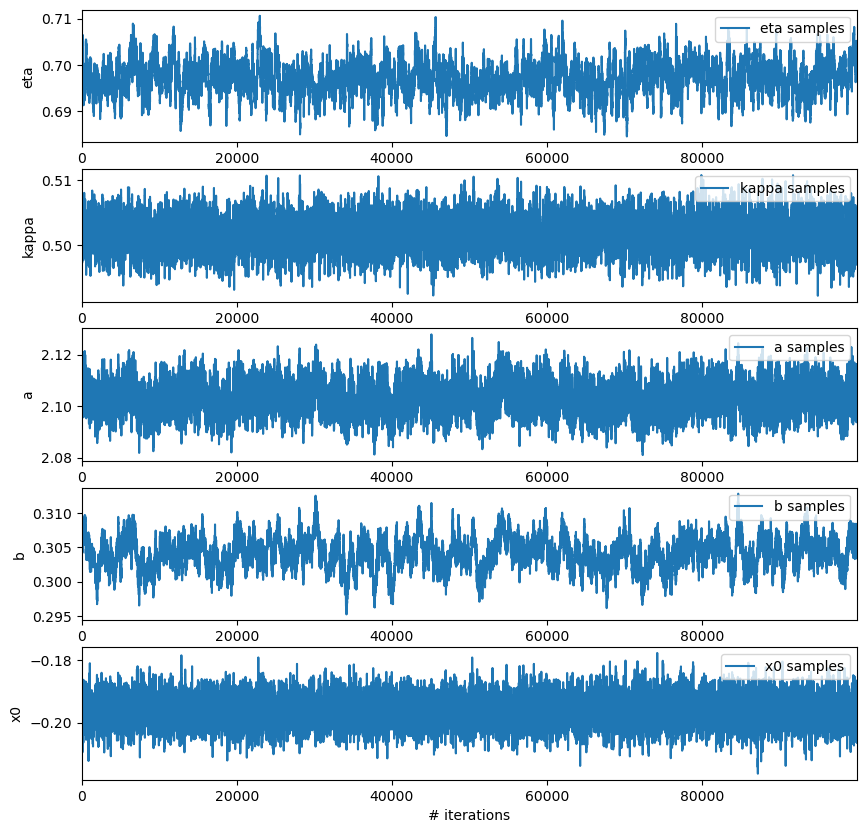

In [21]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
for i, name in enumerate(["eta", "kappa", "a", "b", "x0"]):
    ax[i].plot(posterior_out[name], label=name + " samples")
    ax[i].legend(loc="upper right")
    ax[i].autoscale(axis="x", tight=True)
    ax[i].set_ylabel(name)
ax[4].set_xlabel("# iterations")

plt.show()

In [22]:
def run_two_chains(
    z0, n_draws=2000, n_burnIn=1000, rw_std=0.2, thin=1, seeds=(123, 456),
    jitter=None
):
    """
    Run two MCMC chains from overdispersed initializations.
    """
    z0 = np.asarray(z0, dtype=float)

    # make an overdispersed second init by jittering in u-space, then map back
    u0 = z_to_u(z0)
    if jitter is None:
        jitter = np.array([0.5, -0.5, 0.5, -0.5, 0.5], dtype=float)
    else:
        jitter = np.asarray(jitter, dtype=float)
        if jitter.shape != (5,):
            raise ValueError("jitter must be length-5 to match (u_eta, u_kappa, u_a, u_b, u_x0).")

    z0_b = u_to_z(u0 + jitter)

    # run two chains
    results = []
    print("Running chain 1...")
    results.append(
        run_mcmc(
            z0,
            n_draws=n_draws,
            n_burnIn=n_burnIn,
            rw_std=rw_std,
            thin=thin,
            seed=seeds[0],
        )
    )
    print("Running chain 2...")
    results.append(
        run_mcmc(
            z0_b,
            n_draws=n_draws,
            n_burnIn=n_burnIn,
            rw_std=rw_std,
            thin=thin,
            seed=seeds[1],
        )
    )
    return results


In [25]:
posterior_results = run_two_chains(z0, n_draws=50000, n_burnIn=10000, rw_std=0.012, thin=1)

fname = "mcmc_diagnosis_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
with open(fname, "wb") as f:
    pickle.dump(posterior_results, f)

Running chain 1...
Finish 10000 burn-in iterations, takes 2286.935 seconds.
Finish 50000 MCMC iterations, takes 13760.122 seconds.
Running chain 2...
Finish 10000 burn-in iterations, takes 2298.942 seconds.
Finish 50000 MCMC iterations, takes 13836.046 seconds.


In [23]:
posterior_results = pickle.load(open("mcmc_diagnosis_20251017-035721.pkl", "rb"))

In [24]:
def GelmanRubin_Rhat(param_chains):
    n_chains, n_draws = param_chains.shape
    n = n_draws // 2  # length of each split half
    x = np.concatenate(
        (param_chains[:, :n], param_chains[:, n : 2 * n]), axis=0
    )  # (2*n_chains, n)
    m = x.mean(axis=1)  # mean of each split
    s2 = x.var(axis=1, ddof=1)  # sample var of each split
    W = s2.mean()  # within-split variance
    B = n * m.var(ddof=1)  # between-split variance
    var_plus = ((n - 1) / n) * W + (B / n)
    return np.sqrt(var_plus / W)

In [25]:
def diagnose(results):
    eta_chains = np.vstack([c["eta"] for c in results])
    kappa_chains = np.vstack([c["kappa"] for c in results])
    a_chains = np.vstack([c["a"] for c in results])
    b_chains = np.vstack([c["b"] for c in results])
    x0_chains = np.vstack([c["x0"] for c in results])
    C, N = eta_chains.shape

    # z_chains = np.stack(
    #     [eta_chains, kappa_chains, a_chains, b_chains, x0_chains], axis=-1
    # )
    # u_chains = z_to_u(z_chains)
    # u_eta_chains, u_kappa_chains, u_a_chains, u_b_chains, u_x0_chains = (
    #     u_chains[:, :, 0],
    #     u_chains[:, :, 1],
    #     u_chains[:, :, 2],
    #     u_chains[:, :, 3],
    #     u_chains[:, :, 4],
    # )

    # Gelman-Rubin R-hat statistics
    rhat_eta, rhat_kappa, rhat_a, rhat_b, rhat_x0 = (
        GelmanRubin_Rhat(eta_chains),
        GelmanRubin_Rhat(kappa_chains),
        GelmanRubin_Rhat(a_chains),
        GelmanRubin_Rhat(b_chains),
        GelmanRubin_Rhat(x0_chains),
    )

    print("[Gelman-Rubin R-hat]")
    print(f"  eta: {rhat_eta:.4f}")
    print(f"  kappa: {rhat_kappa:.4f}")
    print(f"  a    : {rhat_a:.4f}")
    print(f"  b    : {rhat_b:.4f}")
    print(f"  x0   : {rhat_x0:.4f}")

    fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
    for i, name in enumerate(["eta", "kappa", "a", "b", "x0"]):
        for j in range(C):
            ax[i].plot(
                results[j][name], alpha=0.8, label=f"chain {j+1}, " + name + " samples"
            )
        ax[i].legend(loc="upper right")
        ax[i].autoscale(axis="x", tight=True)
        ax[i].set_ylabel(name)
    ax[4].set_xlabel("# iterations")

    plt.show()

[Gelman-Rubin R-hat]
  eta: 1.0049
  kappa: 1.0006
  a    : 1.0100
  b    : 1.0316
  x0   : 1.0004


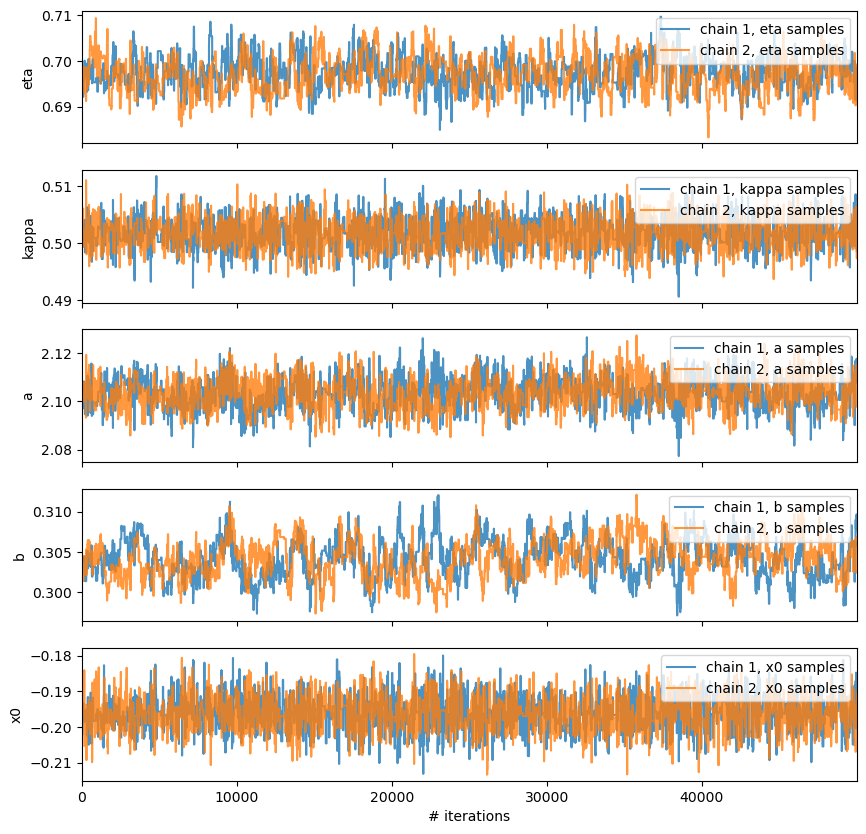

In [26]:
diagnose(posterior_results)